In [6]:
import pandas as pd
from io import StringIO

import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt


def plot_ess(training_scanner_log, ax):
    # Sampling time
    with open(training_scanner_log) as f:
        lines = f.readlines()
    # lines = [line for line in lines if "loader-reset" in line]
    lines = [','.join(line.split(',')[:6]) + '\n' for line in lines if "loader-reset" in line]
    df_ess = pd.read_csv(StringIO(''.join(lines)), sep=",",
                         names=["_1", "time", "_2", "_3", "ess", "avg_weight"])
    df_ess["ess"] = df_ess["ess"].astype(df_ess["time"].dtype)
    df_ess.plot(x="time", y="ess", ax=ax, label=prefix + "ess")
    df_ess.plot(x="time", y="avg_weight", ax=ax, label=prefix + "avg_weight")


def plot(training_head_log, testing_log=None, ax=None, prefix="", color="blue", sizelimit=None):
    # Training time
    with open(training_head_log) as f:
        lines = f.readlines()
    lines = [line for line in lines if "new updates" in line]
    df_train = pd.read_csv(StringIO(''.join(lines)), sep=",",
                           names=["_1", "training time", "_2", "_3", "_4", "modelsize"])
    df_train = df_train[["training time", "modelsize"]]

    ##### TEMPORARY ########
    if False: # "1scanner" in training_head_log:
        with open(training_head_log.replace("log-head", "ret")) as f:
            lines = f.readlines()

        modelsizes = []
        ts = []
        for line in lines[1:]:
            s = line.split()
            try:
                model_size = int(s[8].split("-v")[1].split(".")[0])
            except:
                print(' '.join(s))
                continue
            timestamp = s[6]
            hour, minute, sec = timestamp.split(":")
            timestamp = float(sec) + float(minute) * 60 + float(hour) * 60 * 60
            if True: # start <= model_size <= end:
                modelsizes.append(model_size)
                ts.append(timestamp)

        ts = np.array(ts)
        ts_avg = np.mean(ts[1:] - ts[:-1])
        ts = ts - ts[0] + ts_avg + df_train["training time"].iloc[-1]

        df2 = pd.DataFrame.from_dict({"training time": ts, "modelsize": modelsizes})
        df_train = pd.concat([df_train, df2])
    ##########################

    if sizelimit is not None:
        df_train = df_train[df_train["modelsize"] <= sizelimit]
    df_train = df_train.set_index("modelsize")
    df_train["period"] = (df_train["training time"] / 100).astype(int) * 100


    # Accuracy
    if testing_log is not None:
        with open(testing_log) as f:
            lines = f.readlines()
        lines = [line for line in lines if "sparrow::testing" in line]
        df = pd.read_csv(StringIO(''.join(lines)), sep=",", names=["_1", "testing time", "_2", "_3", "_4", "_modelsize", "modelsize", "loss", "auprc", "auroc", "error rate"])
        df = df.set_index("modelsize")
        df["training time"] = df_train["training time"]

        df = df.reset_index()[["modelsize", "training time", "loss", "auprc", "auroc"]]
        if sizelimit is not None:
            df = df[df["modelsize"] <= sizelimit]

    with open(training_head_log) as f:
        lines = f.readlines()
    lines = [line for line in lines if "finished, write new sample to s3" in line]
    df_sample = pd.read_csv(StringIO(''.join(lines)), sep=",",
                            names=["_1", "time", "_2", "_3", "_4", "_5", "version"])
    sample_time = df_sample["time"]
    # print(list(sample_time))
    df_sample

    # Gamma
    with open(training_head_log) as f:
        lines = f.readlines()
    lines = [line for line in lines if "gamma update" in line]
    df_node = pd.read_csv(StringIO(''.join(lines)), sep=",",
                          names=["_1", "time", "_2", "_3", "_4", "version", "gamma", "shrink_fact", "model_size", "_5", "_6"])

    # Success rate
    with open(training_head_log) as f:
        lines = f.readlines()
    lines = [line for line in lines if "update condition" in line]
    df_suc = pd.read_csv(StringIO(''.join(lines)), sep=",",
                          names=["_1", "training time", "_2", "_3", "_4", "_5", "num_success", "success_rate"])


    # Plotting

    new_plot = False
    if ax is None:
        fig, ax = plt.subplots(3, 2, figsize=(20, 24))
        new_plot = True
    if prefix:
        prefix = prefix + " "

    if testing_log is not None:
        df.plot(x="training time", y="loss", ax=ax[0][0], label=prefix + "loss")
        df.plot(x="training time", y="auroc", ax=ax[0][0], label=prefix + "auroc")
        df.plot(x="training time", y="loss", ax=ax[0][1], label=prefix + "loss")
        df.plot(x="training time", y="auroc", ax=ax[0][1], label=prefix + "auroc")

    df_node.plot(x="time", y="gamma", ax=ax[1][1], label=prefix + "gamma", logy=True)
    # df.plot(x="modelsize", y="loss", ax=ax[1][1], label=prefix + "loss")

    df_train = df_train.reset_index()
    df_train["training time"].hist(bins=100, ax=ax[2][1])
    df_train.plot(x="training time", y="modelsize", ax=ax[1][0], label=prefix + "model size")


    # print(df_ess.head())
    df_suc.plot.scatter(x="training time", y="success_rate", ax=ax[2][0], label=prefix + "success_rate", color=color)


    for i in range(3):
        for j in range(2):
            ax[i][j].grid()
            if False: #new_plot:
                for s in sample_time:
                    ax[i][j].axvline(s, c="gray", ls="--")

    ax[0][0].set_title("Loss and AUROC on the testing set")
    ax[1][1].set_title("Value of gamma over the training time")
    ax[1][0].set_title("Model size over the training time")
    ax[2][1].set_title("Number of the model generated in each period")
    ax[2][0].set_title("Success rate of the updates")

    ax[0][1].set_title("Loss and AUROC on the testing set (zoom-in)")
    ax[0][1].set_ylim(0.8, 1.0)
    ax[0][1].set_ylim(0.048, 0.3)

    ax[1][1].set_ylim(0.0, 0.1)

    return ax

<ipython-input-6-839c92f2e025>:148: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[1][1].set_ylim(0.0, 0.1)
<ipython-input-6-839c92f2e025>:148: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[1][1].set_ylim(0.0, 0.1)
<ipython-input-6-839c92f2e025>:148: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[1][1].set_ylim(0.0, 0.1)


(0.048, 0.07)

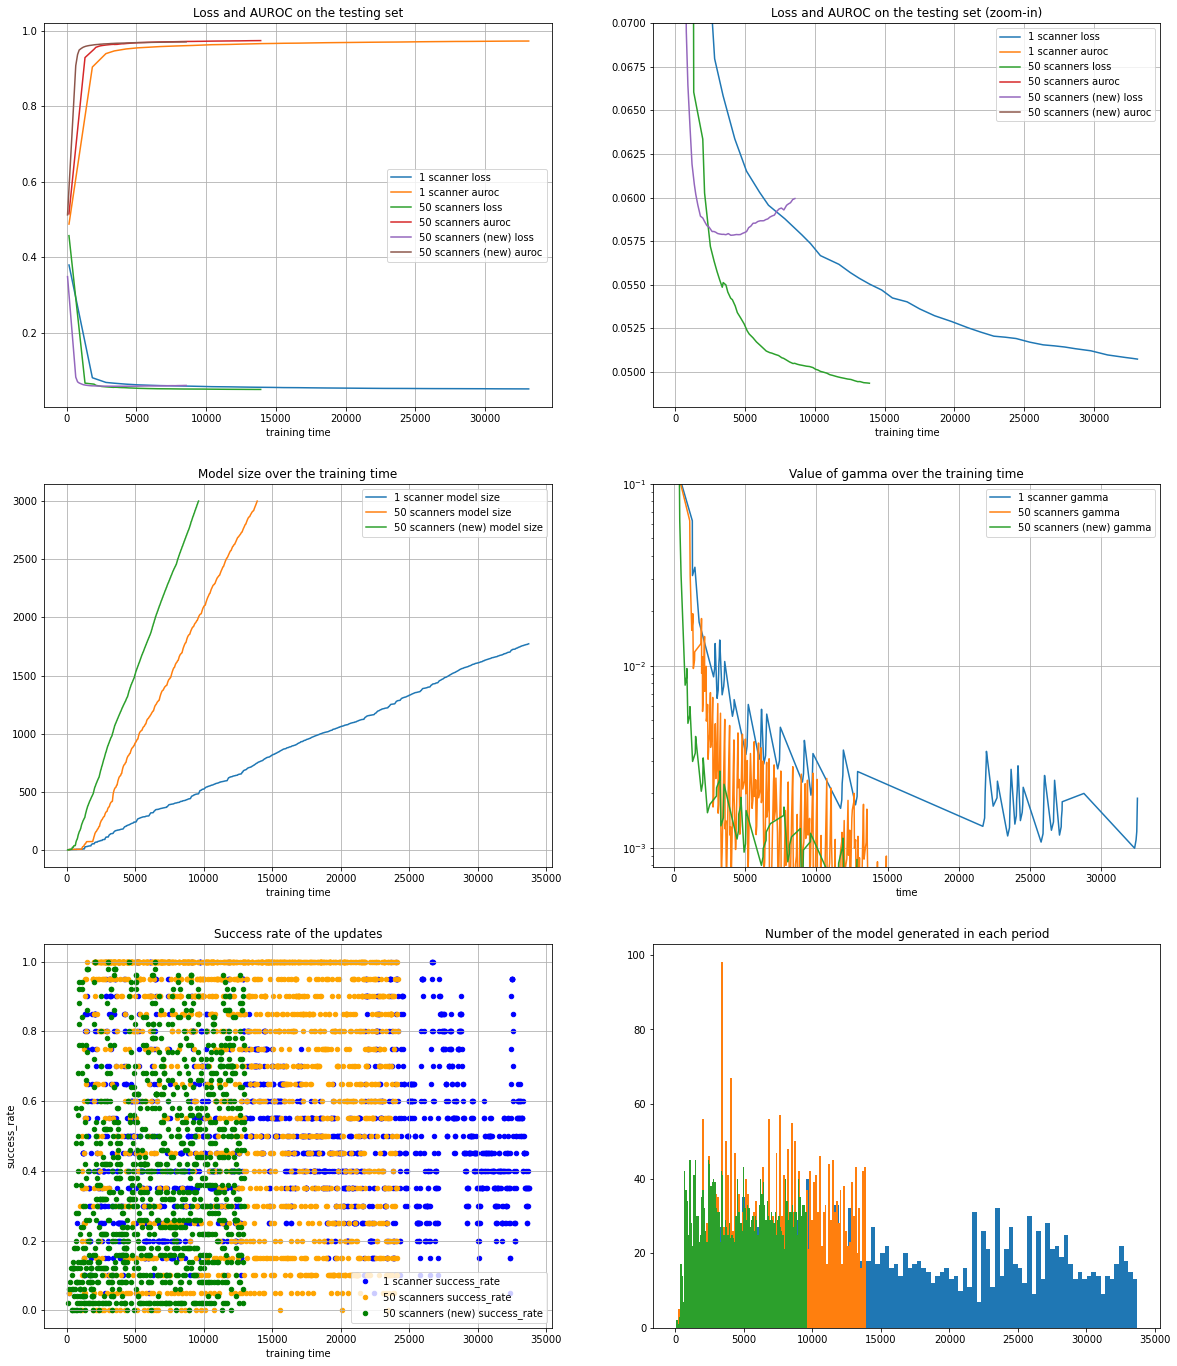

In [9]:
dir_name = "_tree-exp-1/"
TRAINING_LOG = dir_name + "log-head.txt"
TESTING_LOG = dir_name + "testing.log"

ax = plot(TRAINING_LOG, TESTING_LOG, prefix="1 scanner", color="blue", sizelimit=3000)


dir_name = "_tree-exp-50/"
TRAINING_LOG = dir_name + "log-head.txt"
TESTING_LOG = dir_name + "testing.log"

ax = plot(TRAINING_LOG, TESTING_LOG, ax=ax, prefix="50 scanners", color="orange", sizelimit=3000)


dir_name = "_tree-exp-50-2/"
TRAINING_LOG = dir_name + "log-head.txt"
TESTING_LOG = dir_name + "testing.log"

ax = plot(TRAINING_LOG, TESTING_LOG, ax=ax, prefix="50 scanners (new)", color="green", sizelimit=3000)

ax[0][1].set_ylim(0.048, 0.07)

# "red"

<ipython-input-25-2cb27b9b94fd>:148: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[1][1].set_ylim(0.0, 0.1)
<ipython-input-25-2cb27b9b94fd>:148: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[1][1].set_ylim(0.0, 0.1)
<ipython-input-25-2cb27b9b94fd>:148: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[1][1].set_ylim(0.0, 0.1)


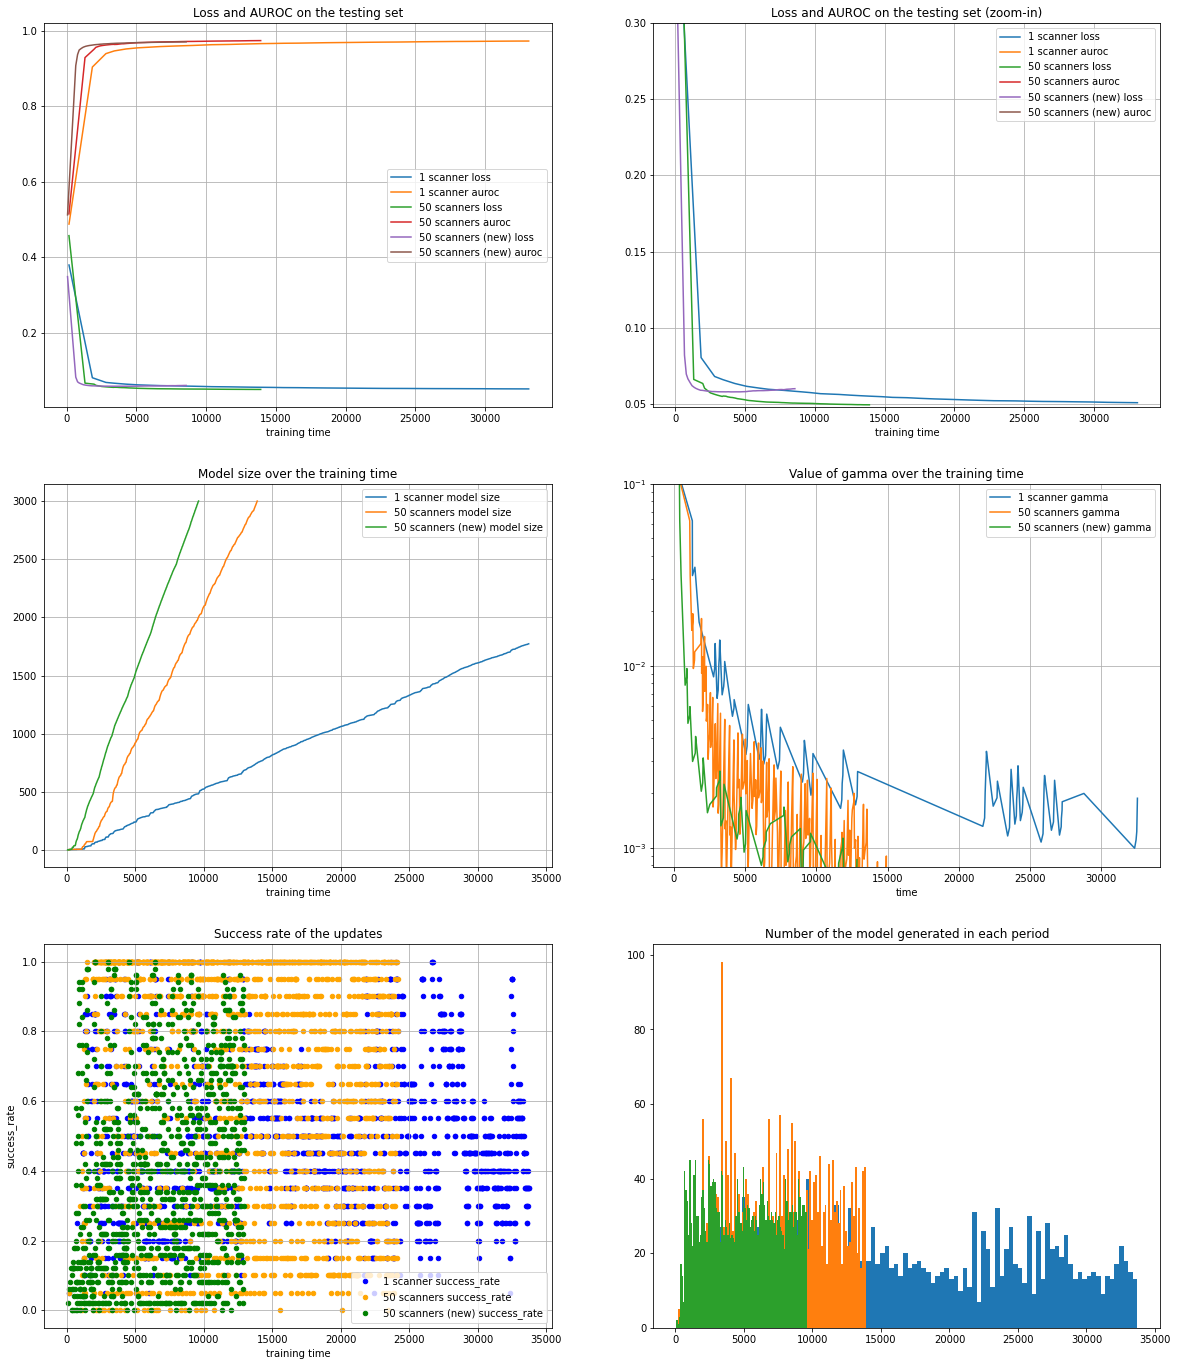

In [26]:
dir_name = "_tree-exp-1/"
TRAINING_LOG = dir_name + "log-head.txt"
TESTING_LOG = dir_name + "testing.log"

ax = plot(TRAINING_LOG, TESTING_LOG, prefix="1 scanner", color="blue", sizelimit=3000)


dir_name = "_tree-exp-50/"
TRAINING_LOG = dir_name + "log-head.txt"
TESTING_LOG = dir_name + "testing.log"

ax = plot(TRAINING_LOG, TESTING_LOG, ax=ax, prefix="50 scanners", color="orange", sizelimit=3000)


dir_name = "_tree-exp-50-2/"
TRAINING_LOG = dir_name + "log-head.txt"
TESTING_LOG = dir_name + "testing.log"

ax = plot(TRAINING_LOG, TESTING_LOG, ax=ax, prefix="50 scanners (new)", color="green", sizelimit=3000)


# "red"

In [20]:
import pandas as pd
from io import StringIO

import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt


def plot_ess(training_scanner_log, ax):
    # Sampling time
    with open(training_scanner_log) as f:
        lines = f.readlines()
    # lines = [line for line in lines if "loader-reset" in line]
    lines = [','.join(line.split(',')[:6]) + '\n' for line in lines if "loader-reset" in line]
    df_ess = pd.read_csv(StringIO(''.join(lines)), sep=",",
                         names=["_1", "time", "_2", "_3", "ess", "avg_weight"])
    df_ess["ess"] = df_ess["ess"].astype(df_ess["time"].dtype)
    df_ess.plot(x="time", y="ess", ax=ax, label=prefix + "ess")
    df_ess.plot(x="time", y="avg_weight", ax=ax, label=prefix + "avg_weight")


def plot(training_head_log, testing_log=None, ax=None, prefix="", color="blue", sizelimit=None):
    # Training time
    with open(training_head_log) as f:
        lines = f.readlines()
    lines = [line for line in lines if "new updates" in line]
    df_train = pd.read_csv(StringIO(''.join(lines)), sep=",",
                           names=["_1", "training time", "_2", "_3", "_4", "modelsize"])
    df_train = df_train[["training time", "modelsize"]]

    ##### TEMPORARY ########
    if False: # "1scanner" in training_head_log:
        with open(training_head_log.replace("log-head", "ret")) as f:
            lines = f.readlines()

        modelsizes = []
        ts = []
        for line in lines[1:]:
            s = line.split()
            try:
                model_size = int(s[8].split("-v")[1].split(".")[0])
            except:
                print(' '.join(s))
                continue
            timestamp = s[6]
            hour, minute, sec = timestamp.split(":")
            timestamp = float(sec) + float(minute) * 60 + float(hour) * 60 * 60
            if True: # start <= model_size <= end:
                modelsizes.append(model_size)
                ts.append(timestamp)

        ts = np.array(ts)
        ts_avg = np.mean(ts[1:] - ts[:-1])
        ts = ts - ts[0] + ts_avg + df_train["training time"].iloc[-1]

        df2 = pd.DataFrame.from_dict({"training time": ts, "modelsize": modelsizes})
        df_train = pd.concat([df_train, df2])
    ##########################

    if sizelimit is not None:
        df_train = df_train[df_train["modelsize"] <= sizelimit]
    df_train = df_train.set_index("modelsize")
    df_train["period"] = (df_train["training time"] / 100).astype(int) * 100


    # Accuracy
    if testing_log is not None:
        with open(testing_log) as f:
            lines = f.readlines()
        lines = [line for line in lines if "sparrow::testing" in line]
        df = pd.read_csv(StringIO(''.join(lines)), sep=",", names=["_1", "testing time", "_2", "_3", "_4", "_modelsize", "modelsize", "loss", "auprc", "auroc", "error rate"])
        df = df.set_index("modelsize")
        df["training time"] = df_train["training time"]

        df = df.reset_index()[["modelsize", "training time", "loss", "auprc", "auroc"]]
        if sizelimit is not None:
            df = df[df["modelsize"] <= sizelimit]

    with open(training_head_log) as f:
        lines = f.readlines()
    lines = [line for line in lines if "finished, write new sample to s3" in line]
    df_sample = pd.read_csv(StringIO(''.join(lines)), sep=",",
                            names=["_1", "time", "_2", "_3", "_4", "_5", "version"])
    sample_time = df_sample["time"]
    # print(list(sample_time))
    df_sample

    # Gamma
    with open(training_head_log) as f:
        lines = f.readlines()
    lines = [line for line in lines if "gamma update" in line]
    df_node = pd.read_csv(StringIO(''.join(lines)), sep=",",
                          names=["_1", "time", "_2", "_3", "_4", "version", "gamma", "shrink_fact", "model_size", "_5", "_6"])

    # Success rate
    with open(training_head_log) as f:
        lines = f.readlines()
    lines = [line for line in lines if "update condition" in line]
    df_suc = pd.read_csv(StringIO(''.join(lines)), sep=",",
                          names=["_1", "training time", "_2", "_3", "_4", "_5", "num_success", "success_rate"])


    # Plotting

    new_plot = False
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        new_plot = True
    if prefix:
        prefix = prefix + " "

    if testing_log is not None:
        # df.plot(x="training time", y="loss", ax=ax[0][0], label=prefix + "loss")
        # df.plot(x="training time", y="auroc", ax=ax[0][0], label=prefix + "auroc")
        df.plot(x="training time", y="loss", ax=ax, label=prefix) # ax=ax[0][1], label=prefix + "loss")
        # df.plot(x="training time", y="auroc", ax=ax[0][1], label=prefix + "auroc")

    '''
    df_node.plot(x="time", y="gamma", ax=ax[1][1], label=prefix + "gamma")
    # df.plot(x="modelsize", y="loss", ax=ax[1][1], label=prefix + "loss")

    df_train = df_train.reset_index()
    df_train["training time"].hist(bins=100, ax=ax[2][1])
    df_train.plot(x="training time", y="modelsize", ax=ax[1][0], label=prefix + "model size")


    # print(df_ess.head())
    df_suc.plot.scatter(x="training time", y="success_rate", ax=ax[2][0], label=prefix + "success_rate", color=color)


    for i in range(3):
        for j in range(2):
            ax[i][j].grid()
            if False: #new_plot:
                for s in sample_time:
                    ax[i][j].axvline(s, c="gray", ls="--")

    ax[0][0].set_title("Loss and AUROC on the testing set")
    ax[1][1].set_title("Value of gamma over the training time")
    ax[1][0].set_title("Model size over the training time")
    ax[2][1].set_title("Number of the model generated in each period")
    ax[2][0].set_title("Success rate of the updates")
    '''
    # [0][1]
    ax.set_title("Exponential loss evaluated on the testing set (zoom-in)")
    # ax[0][1].set_ylim(0.8, 1.0)
    ax.set_ylim(0.048, 0.065)

    # ax[1][1].set_ylim(0.0, 0.005)

    return df, ax

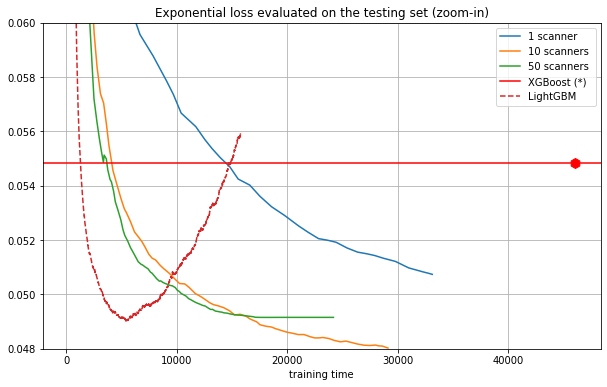

In [38]:
dir_name = "_tree-exp-1/"
TRAINING_LOG = dir_name + "log-head.txt"
TESTING_LOG = dir_name + "testing.log"

_, ax = plot(TRAINING_LOG, TESTING_LOG, prefix="1 scanner", color="blue", sizelimit=None)


dir_name = "_tree-exp-10/"
TRAINING_LOG = dir_name + "log-head.txt"
TESTING_LOG = dir_name + "testing.log"

_, ax = plot(TRAINING_LOG, TESTING_LOG, ax=ax, prefix="10 scanners", color="orange", sizelimit=None)


dir_name = "_tree-exp-50/"
TRAINING_LOG = dir_name + "log-head.txt"
TESTING_LOG = dir_name + "testing.log"

df, ax = plot(TRAINING_LOG, TESTING_LOG, ax=ax, prefix="50 scanners", color="green", sizelimit=None)

import matplotlib
ax.axhline(0.054832, color="red", label="XGBoost (*)")
plt.plot([46059.49019], [0.054832], 'rh', markersize=10)
# ax.axhline(0.053186, color="red", ls="--", label="LightGBM (*)")
# plt.plot([4197.08978], [0.053186], 'rh', markersize=10)
plt.plot(training_time, performance, ls="--", label="LightGBM")
ax.legend()
ax.grid()

# "red"

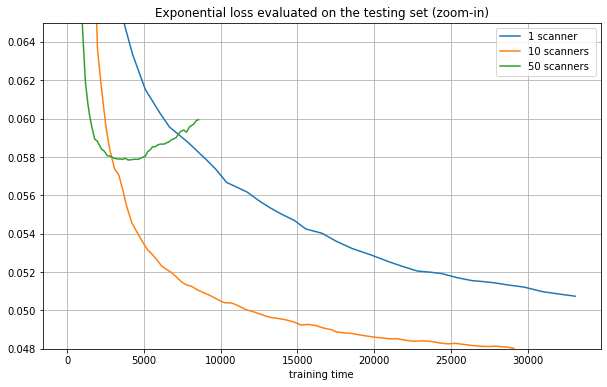

In [21]:
dir_name = "_tree-exp-1/"
TRAINING_LOG = dir_name + "log-head.txt"
TESTING_LOG = dir_name + "testing.log"

_, ax = plot(TRAINING_LOG, TESTING_LOG, prefix="1 scanner", color="blue", sizelimit=None)


dir_name = "_tree-exp-10/"
TRAINING_LOG = dir_name + "log-head.txt"
TESTING_LOG = dir_name + "testing.log"

_, ax = plot(TRAINING_LOG, TESTING_LOG, ax=ax, prefix="10 scanners", color="orange", sizelimit=None)


dir_name = "_tree-exp-50-2/"
TRAINING_LOG = dir_name + "log-head.txt"
TESTING_LOG = dir_name + "testing.log"

df, ax = plot(TRAINING_LOG, TESTING_LOG, ax=ax, prefix="50 scanners", color="green", sizelimit=None)

import matplotlib
# ax.axhline(0.054832, color="red", label="XGBoost (*)")
# plt.plot([46059.49019], [0.054832], 'rh', markersize=10)
# ax.axhline(0.053186, color="red", ls="--", label="LightGBM (*)")
# plt.plot([4197.08978], [0.053186], 'rh', markersize=10)
# plt.plot(training_time, performance, ls="--", label="LightGBM")
ax.legend()
ax.grid()

# "red"

(0.048, 0.07)

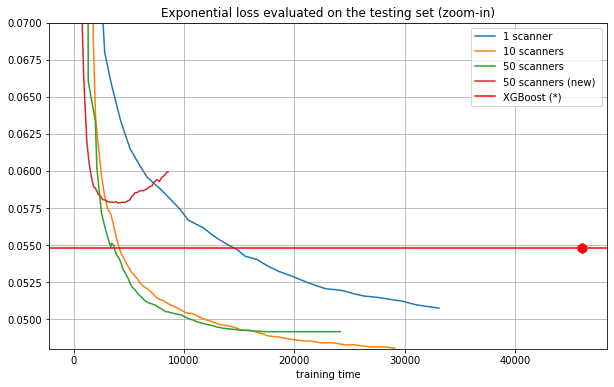

In [17]:
dir_name = "_tree-exp-1/"
TRAINING_LOG = dir_name + "log-head.txt"
TESTING_LOG = dir_name + "testing.log"

_, ax = plot(TRAINING_LOG, TESTING_LOG, prefix="1 scanner", color="blue", sizelimit=None)


dir_name = "_tree-exp-10/"
TRAINING_LOG = dir_name + "log-head.txt"
TESTING_LOG = dir_name + "testing.log"

_, ax = plot(TRAINING_LOG, TESTING_LOG, ax=ax, prefix="10 scanners", color="orange", sizelimit=None)


dir_name = "_tree-exp-50/"
TRAINING_LOG = dir_name + "log-head.txt"
TESTING_LOG = dir_name + "testing.log"

_, ax = plot(TRAINING_LOG, TESTING_LOG, ax=ax, prefix="50 scanners", color="green", sizelimit=None)


dir_name = "_tree-exp-50-2/"
TRAINING_LOG = dir_name + "log-head.txt"
TESTING_LOG = dir_name + "testing.log"

df, ax = plot(TRAINING_LOG, TESTING_LOG, ax=ax, prefix="50 scanners (new)", color="red", sizelimit=None)


import matplotlib
ax.axhline(0.054832, color="red", label="XGBoost (*)")
plt.plot([46059.49019], [0.054832], 'rh', markersize=10)
# ax.axhline(0.053186, color="red", ls="--", label="LightGBM (*)")
# plt.plot([4197.08978], [0.053186], 'rh', markersize=10)
# plt.plot(training_time, performance, ls="--", label="LightGBM")
ax.legend()
ax.grid()
ax.set_ylim(0.048, 0.07)
# "red"

* According to the threshold, change the colors of the points in Success rate of the updates.

In [13]:
with open("/Users/arapat/Downloads/log2.txt") as f:
    lines = f.readlines()

In [14]:
lines = [line for line in lines if "added new rule" in line]

In [15]:
df = pd.read_csv(StringIO(''.join(lines)), sep=",",
                names=["_1", "time", "_2", "_3", "_4", "modelsize", "scanned", "total", "lef", "right"])
df[df["lef"] != 1]["scanned"].mean()

916379.7445583738

In [16]:
with open("/Users/arapat/Downloads/log2.txt") as f:
    lines = f.readlines()

In [17]:
full_scan = []
stop_rule = []
for i in range(len(lines) - 1):
    if "Start training" in lines[i] and "loader-reset" in lines[i + 1]:
        a = float(lines[i].split(", ")[1])
        b = float(lines[i + 1].split(", ")[1])
        full_scan.append(b - a)
    if "added new rule" in lines[i] and "tree-node-info" in lines[i + 1]:
        a = float(lines[i].split(", ")[1])
        b = float(lines[i + 1].split(", ")[1])
        stop_rule.append(b - a)

In [122]:
np.mean(full_scan)

0.02599470145514998

In [125]:
np.mean(stop_rule)

1.6574334773576878